In [1]:
import phoebe
import numpy as np
from phoebe import u
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: how to save?
import pickle

with open('test_binary.pickle', 'rb') as f:
    b = pickle.load(f)
    
from spectrum_nn import flux
import jax.numpy as jnp
import jax

from phoebe_utils import PhoebeConfig

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: timeout timed out


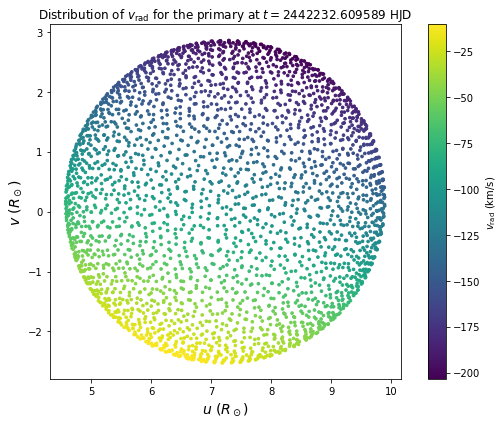

In [2]:
config = PhoebeConfig(b, 'bigmesh')
time = config.times[0]

coords = config.get_mesh_coordinates(time)
VW = config.get_radial_velocities(time)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[:, 0], coords[:, 1], marker='o',c=VW,s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $v_{\rm rad}$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label=r'$v_{\rm rad}$ (km/s)')
plt.tight_layout()
plt.show()

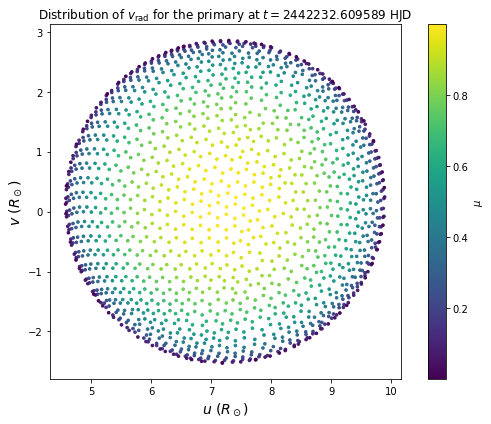

In [3]:
mus = config.get_mus(time)

pos_mus = np.argwhere(mus>0)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[pos_mus, 0], coords[pos_mus, 1], marker='o',c=mus[pos_mus],s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $v_{\rm rad}$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label='$\mu$')
plt.tight_layout()
plt.show()

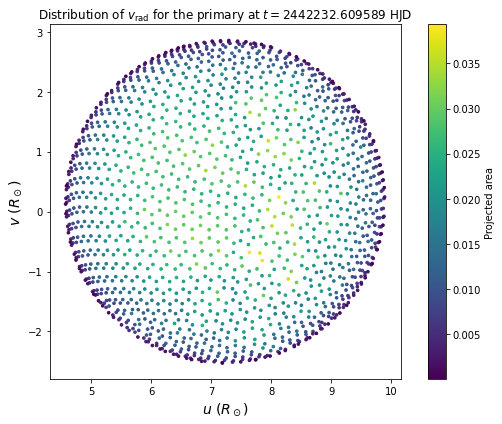

In [4]:
projected_areas = config.get_projected_areas(time)

pos_mus = np.argwhere(mus>0)

#example plot of the radial velocities of centers of triangular surface elements for the primary component
#just to show/check that everything works fine and smoothly :)
plt.figure(figsize=(8,6))
plt.gca().set_aspect('equal')
plt.scatter(coords[pos_mus, 0], coords[pos_mus, 1], marker='o',c=projected_areas[pos_mus],s=7)
plt.xlabel(r'$u$ ($R_\odot$)',fontsize=14)
plt.ylabel(r'$v$ ($R_\odot$)',fontsize=14)
plt.title(r'Distribution of $v_{\rm rad}$ for the primary at $t=$'+str(time)+' HJD',fontsize=12)
plt.colorbar(label='Projected area')
plt.tight_layout()
plt.show()

In [5]:
np.sum(projected_areas[pos_mus])

22.516406337581266

In [6]:
mus = jnp.array(mus[pos_mus])
areas = jnp.array(projected_areas[pos_mus])

In [7]:
atmosphere_flux = jax.jit(jax.vmap(flux, in_axes=(None, 0)))

In [8]:
from functools import partial

In [9]:
mus.shape

(1453, 1)

In [10]:
areas.shape

(1453, 1)

In [14]:
CHUNK_SIZE = 256
from jax import lax
import math

def _flash_sum(areas, mus, precision=10000):
    # Just the 1D case for now
    n_areas, n_samples = areas.shape
    mus_flattened = mus.reshape(areas.shape)

    @partial(jax.checkpoint, prevent_cse=False)
    def chunk_scanner(carries, _):
        chunk_idx, atmo_sun = carries
        k_chunk_sizes = min(CHUNK_SIZE, n_areas)

        a_chunk = lax.dynamic_slice(areas,
                                    (chunk_idx, 0),
                                    (k_chunk_sizes, n_samples))
        m_chunk = lax.dynamic_slice(mus_flattened,
                                    (chunk_idx, 0),
                                    (k_chunk_sizes, n_samples))

        new_atmo_sum = atmo_sun + jnp.sum(
            jnp.multiply(
                a_chunk.reshape((-1, 1, 1)),
                atmosphere_flux(jnp.linspace(0, 1, precision),
                                jnp.ones_like(m_chunk).flatten())
            ), axis=0)
        return (chunk_idx + k_chunk_sizes, new_atmo_sum), None

    (_, out), lse = lax.scan(chunk_scanner, init=(0, jnp.zeros((precision, 2))), xs=None, length=math.ceil(n_areas/CHUNK_SIZE))
    return out

In [12]:
atmosphere = jnp.sum(
    jnp.multiply(
        areas.reshape((-1, 1, 1)),
        atmosphere_flux(jnp.linspace(0, 1, 1000000),
                        jnp.ones_like(mus).flatten())), axis=0)/jnp.sum(areas)

2023-01-02 20:18:43.461791: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 10.83GiB (rounded to 11624000000)requested by op 
2023-01-02 20:18:43.462405: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-01-02 20:18:43.462655: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2163] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 11624000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.82MiB
              constant allocation:    8.51MiB
        maybe_live_out allocation:   10.83GiB
     preallocated temp allocation:  984.20MiB
                 total allocation:   11.80GiB
              total fragmentation:  985.07MiB (8.15%)
Peak buffers:
	Buff

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 11624000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.82MiB
              constant allocation:    8.51MiB
        maybe_live_out allocation:   10.83GiB
     preallocated temp allocation:  984.20MiB
                 total allocation:   11.80GiB
              total fragmentation:  985.07MiB (8.15%)
Peak buffers:
	Buffer 1:
		Size: 10.83GiB
		Operator: op_name="jit(flux)/jit(main)/vmap(MLP_wavelength_sine_mu)/scatter-add[update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(0, 1), inserted_window_dims=(2,), scatter_dims_to_operand_dims=(2,)) indices_are_sorted=True unique_indices=True mode=GatherScatterMode.FILL_OR_DROP]" source_file="/notebooks/stellar-mesh-integration/spectrum_nn.py" source_line=51
		XLA Label: fusion
		Shape: f32[1453,1000000,2]
		==========================

	Buffer 2:
		Size: 976.56MiB
		Operator: op_name="jit(flux)/jit(main)/vmap(MLP_wavelength_sine_mu)/vmap(decoder)/Dense_1/add" source_file="/usr/local/lib/python3.9/dist-packages/flax/linen/linear.py" source_line=203
		XLA Label: broadcast
		Shape: f32[1000000,256]
		==========================

	Buffer 3:
		Size: 7.63MiB
		XLA Label: copy
		Shape: f32[1000000,2]
		==========================

	Buffer 4:
		Size: 7.63MiB
		XLA Label: constant
		Shape: f32[1000000,2]
		==========================

	Buffer 5:
		Size: 3.81MiB
		Entry Parameter Subshape: f32[1000000]
		==========================

	Buffer 6:
		Size: 256.0KiB
		XLA Label: constant
		Shape: f32[256,256]
		==========================

	Buffer 7:
		Size: 256.0KiB
		XLA Label: constant
		Shape: f32[256,256]
		==========================

	Buffer 8:
		Size: 256.0KiB
		XLA Label: constant
		Shape: f32[256,256]
		==========================

	Buffer 9:
		Size: 128.0KiB
		XLA Label: constant
		Shape: f32[128,256]
		==========================

	Buffer 10:
		Size: 5.7KiB
		Operator: op_name="jit(flux)/jit(main)/vmap(MLP_wavelength_sine_mu)/log" source_file="/notebooks/stellar-mesh-integration/spectrum_nn.py" source_line=42
		XLA Label: fusion
		Shape: f32[1453]
		==========================

	Buffer 11:
		Size: 5.7KiB
		Entry Parameter Subshape: f32[1453]
		==========================

	Buffer 12:
		Size: 2.0KiB
		XLA Label: constant
		Shape: f32[256,2]
		==========================

	Buffer 13:
		Size: 1.0KiB
		Operator: op_name="jit(flux)/jit(main)/vmap(MLP_wavelength_sine_mu)/vmap(decoder)/Dense_3/add" source_file="/usr/local/lib/python3.9/dist-packages/flax/linen/linear.py" source_line=203
		XLA Label: constant
		Shape: f32[256]
		==========================

	Buffer 14:
		Size: 1.0KiB
		Operator: op_name="jit(flux)/jit(main)/vmap(MLP_wavelength_sine_mu)/vmap(decoder)/Dense_2/add" source_file="/usr/local/lib/python3.9/dist-packages/flax/linen/linear.py" source_line=203
		XLA Label: constant
		Shape: f32[256]
		==========================

	Buffer 15:
		Size: 1.0KiB
		Operator: op_name="jit(flux)/jit(main)/vmap(MLP_wavelength_sine_mu)/vmap(decoder)/Dense_1/add" source_file="/usr/local/lib/python3.9/dist-packages/flax/linen/linear.py" source_line=203
		XLA Label: constant
		Shape: f32[256]
		==========================



In [13]:
atmo = _flash_sum(areas, mus, 1000000)/jnp.sum(areas)

(1453, 1)


In [15]:
atmo.shape

(1000000, 2)

In [17]:
test_atmo = flux(jnp.linspace(0, 1, 1000000), 1.)

In [18]:
test_flux, test_continuum = test_atmo[:, 0], test_atmo[:, 1]

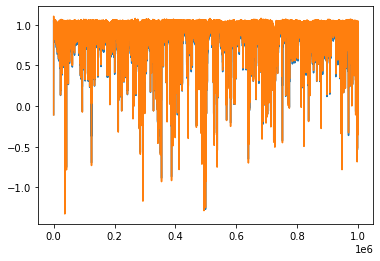

In [19]:
plt.figure()
plt.plot(test_flux);
plt.plot(atmo[:, 0]);